# Ronde van Vlaanderen - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In this notebook, the application of DBSCAN as a hierarchical clustering algorithm is presented with data from a specific competition (Ronde van Vlaanderen) and the cilists who participated in it over the years. This experiment aims at clustering the records in the global dataset according to the most relevant features without separating the information into races and cyclists.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

ModuleNotFoundError: No module named 'kneed'

In [9]:
ronde_dataset = pd.read_csv('../../data/complete_dataset_no_outliers.csv').drop(columns=['profile', 'uci_points', 'mean_cyclist_cp', 'mean_delta', 'mean_position', 'raw_position', 'points'])
ronde_dataset = ronde_dataset[ronde_dataset['race_name'] == 'Ronde van Vlaanderen']
ronde_dataset = ronde_dataset.select_dtypes(include=['number'])
ronde_dataset = ronde_dataset.dropna().reset_index(drop=True)

# drop colums from PCA and UMAP analisis
ronde_dataset = ronde_dataset.drop(['length', 'startlist_quality', 'position', 'delta', 'race_year', 'race_prestige', 'num_participants'], axis=1)

ronde_dataset.info()
columns_to_use = ronde_dataset.columns

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(ronde_dataset)

In [12]:
'''
# Step 1: Calculate the mean delta for each cyclist
mean_delta = dataset.groupby('cyclist_url')['delta'].mean()
mean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean()
mean_height = dataset.groupby('cyclist_url')['height'].mean()
mean_cp = dataset.groupby('cyclist_url')['cyclist_climb_power'].mean()

# Step 2: Map the mean delta back to each row
dataset['mean_delta'] = dataset['cyclist_url'].map(mean_delta)
dataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)
dataset['mean_height'] = dataset['cyclist_url'].map(mean_height)
dataset['mean_cp'] = dataset['cyclist_url'].map(mean_cp)
'''

"\n# Step 1: Calculate the mean delta for each cyclist\nmean_delta = dataset.groupby('cyclist_url')['delta'].mean()\nmean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean()\nmean_height = dataset.groupby('cyclist_url')['height'].mean()\nmean_cp = dataset.groupby('cyclist_url')['cyclist_climb_power'].mean()\n\n# Step 2: Map the mean delta back to each row\ndataset['mean_delta'] = dataset['cyclist_url'].map(mean_delta)\ndataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)\ndataset['mean_height'] = dataset['cyclist_url'].map(mean_height)\ndataset['mean_cp'] = dataset['cyclist_url'].map(mean_cp)\n"

Thanks to the following model selection process, the two parameters of the ‘DBSCAN’ algorithm (‘eps’ and ‘min_samples’) were selected in the context of this case study. Of the options studied in the process, the evaluation was made according to the trade-off between the number of clusters identified and silhouette score.

Each iteration of the model selection process starts with setting the ‘min_points’ parameter, studied in the range 2-20. For each of these alternatives, the optimal value of the ‘eps’ parameter is identified through the identification of the knee-point in the curve defined by the points (k-th distance, index).

Our Knee Method implementation:

- We compute the 𝑘-distance for each point:
    - Choose a value for 𝑘, a tipical choice should be to set to 𝑘 = min_points − 1, where min_points is the minimum number of points required to form a dense region (DBSCAN parameter fixed in the model selection iteration). 
    - For each point in the dataset, we calculate the distance to its 𝑘-th nearest neighbor (𝑘-distance).
- We sort the 𝑘-distances:
    - Arrange all the points by their 𝑘-distance in a 𝑘-distance plot, where the x-axis is the points (sorted) and the y-axis is their 𝑘-distance.
- Plot the 𝑘-distance graph
- Identify the "knee" in the plot: The y-axis typically increases gradually at first and then sharply increases, forming a curve. The knee corresponds to the point of maximum curvature in the graph. It is the location where the slope changes most significantly. Intuitively, it separates the "dense" regions (gradual slope) from the "sparse" regions (steep slope) in the dataset.


To automate the process of knee detection, we relied on the kneed library (KneeLocator).


#### Model Selection

In [ ]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value? TODO: check this
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")
    
    if(kneedle.knee is None):
        optimal_eps.append(None) 
        optimal_index.append(None)  
        silhouette_scores.append(None)
        continue
    
    # Get the knee (selecting automatically the optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    ronde_dataset['cluster'] = clusters
    number_of_clusters = ronde_dataset['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster (label -1) is that of outliers, to compute silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(ronde_dataset[ronde_dataset['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

NameError: name 'squareform' is not defined

In [4]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

NameError: name 'model_selection_df' is not defined

#### Chosen Parameter Clustering

(3994551,)
(2827, 2827)
Optimal epsilon (eps): 2.3574186043784913
Knee point index: 2779


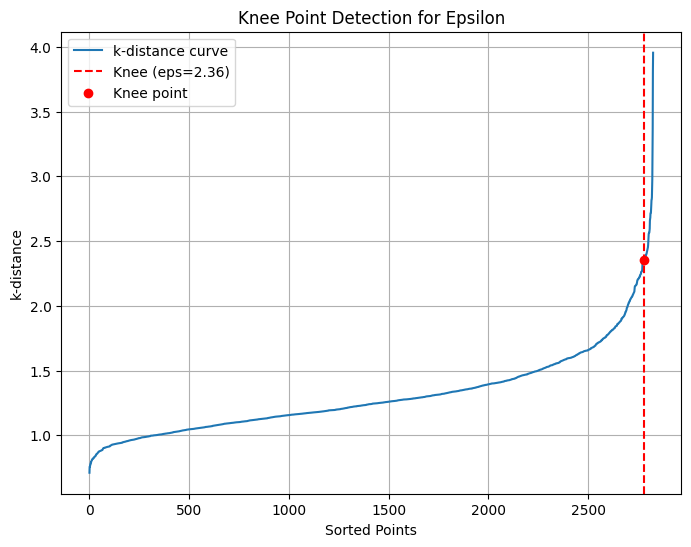

In [17]:
min_points = 10

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [18]:
# Select relevant columns for clustering
columns_to_use = ['length','race_prestige', 'race_physical_effort', 'cyclist_bmi', 'cyclist_age', 'height', 'cyclist_climb_power', 'position', 'delta']

data_for_clustering = dataset[columns_to_use].dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

In [19]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

In [20]:
# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    2664
 2     109
 1      50
-1       4
Name: count, dtype: int64
     length  race_prestige  race_physical_effort  cyclist_bmi  cyclist_age  \
211   256.0       0.334366              0.127849    21.200991           27   
275   269.0       0.432960              0.134341    21.200991           30   
295   269.0       0.447486              0.134341    21.200991           31   
306   264.0       0.324242              0.131844    21.200991           32   
372   257.0       0.443084              0.128348    21.200991           34   

     height  cyclist_climb_power  position   delta  cluster  
211   183.0             0.000035  0.472527   344.0        0  
275   183.0             0.000038  0.431579   303.0        0  
295   183.0             0.000143  0.290698    79.0        0  
306   183.0             0.000012  0.933333  1002.0        0  
372   183.0             0.000091  0.282258   130.0        0  


In [21]:
np.unique(dbscan.labels_, return_counts=True)


(array([-1,  0,  1,  2]), array([   4, 2664,   50,  109]))

In [22]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 4


In [23]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
              length            race_prestige           race_physical_effort  \
               mean        std          mean       std                 mean   
cluster                                                                       
-1       253.775000  13.844704      0.353072  0.023502             0.090155   
 0       261.524737   5.578373      0.385195  0.038834             0.128215   
 1       262.822000   6.099759      0.394588  0.044417             0.129131   
 2       243.300000   0.000000      0.348891  0.000000             0.055214   

                  cyclist_bmi           cyclist_age                height  \
              std        mean       std        mean       std        mean   
cluster                                                                     
-1       0.042278   21.565845  0.942787   28.250000  3.593976  189.250000   
 0       0.006032   21.798430  1.140957   29.108483  4.100303  182.721096   
 1       0.006903   22.041377  1.062489 

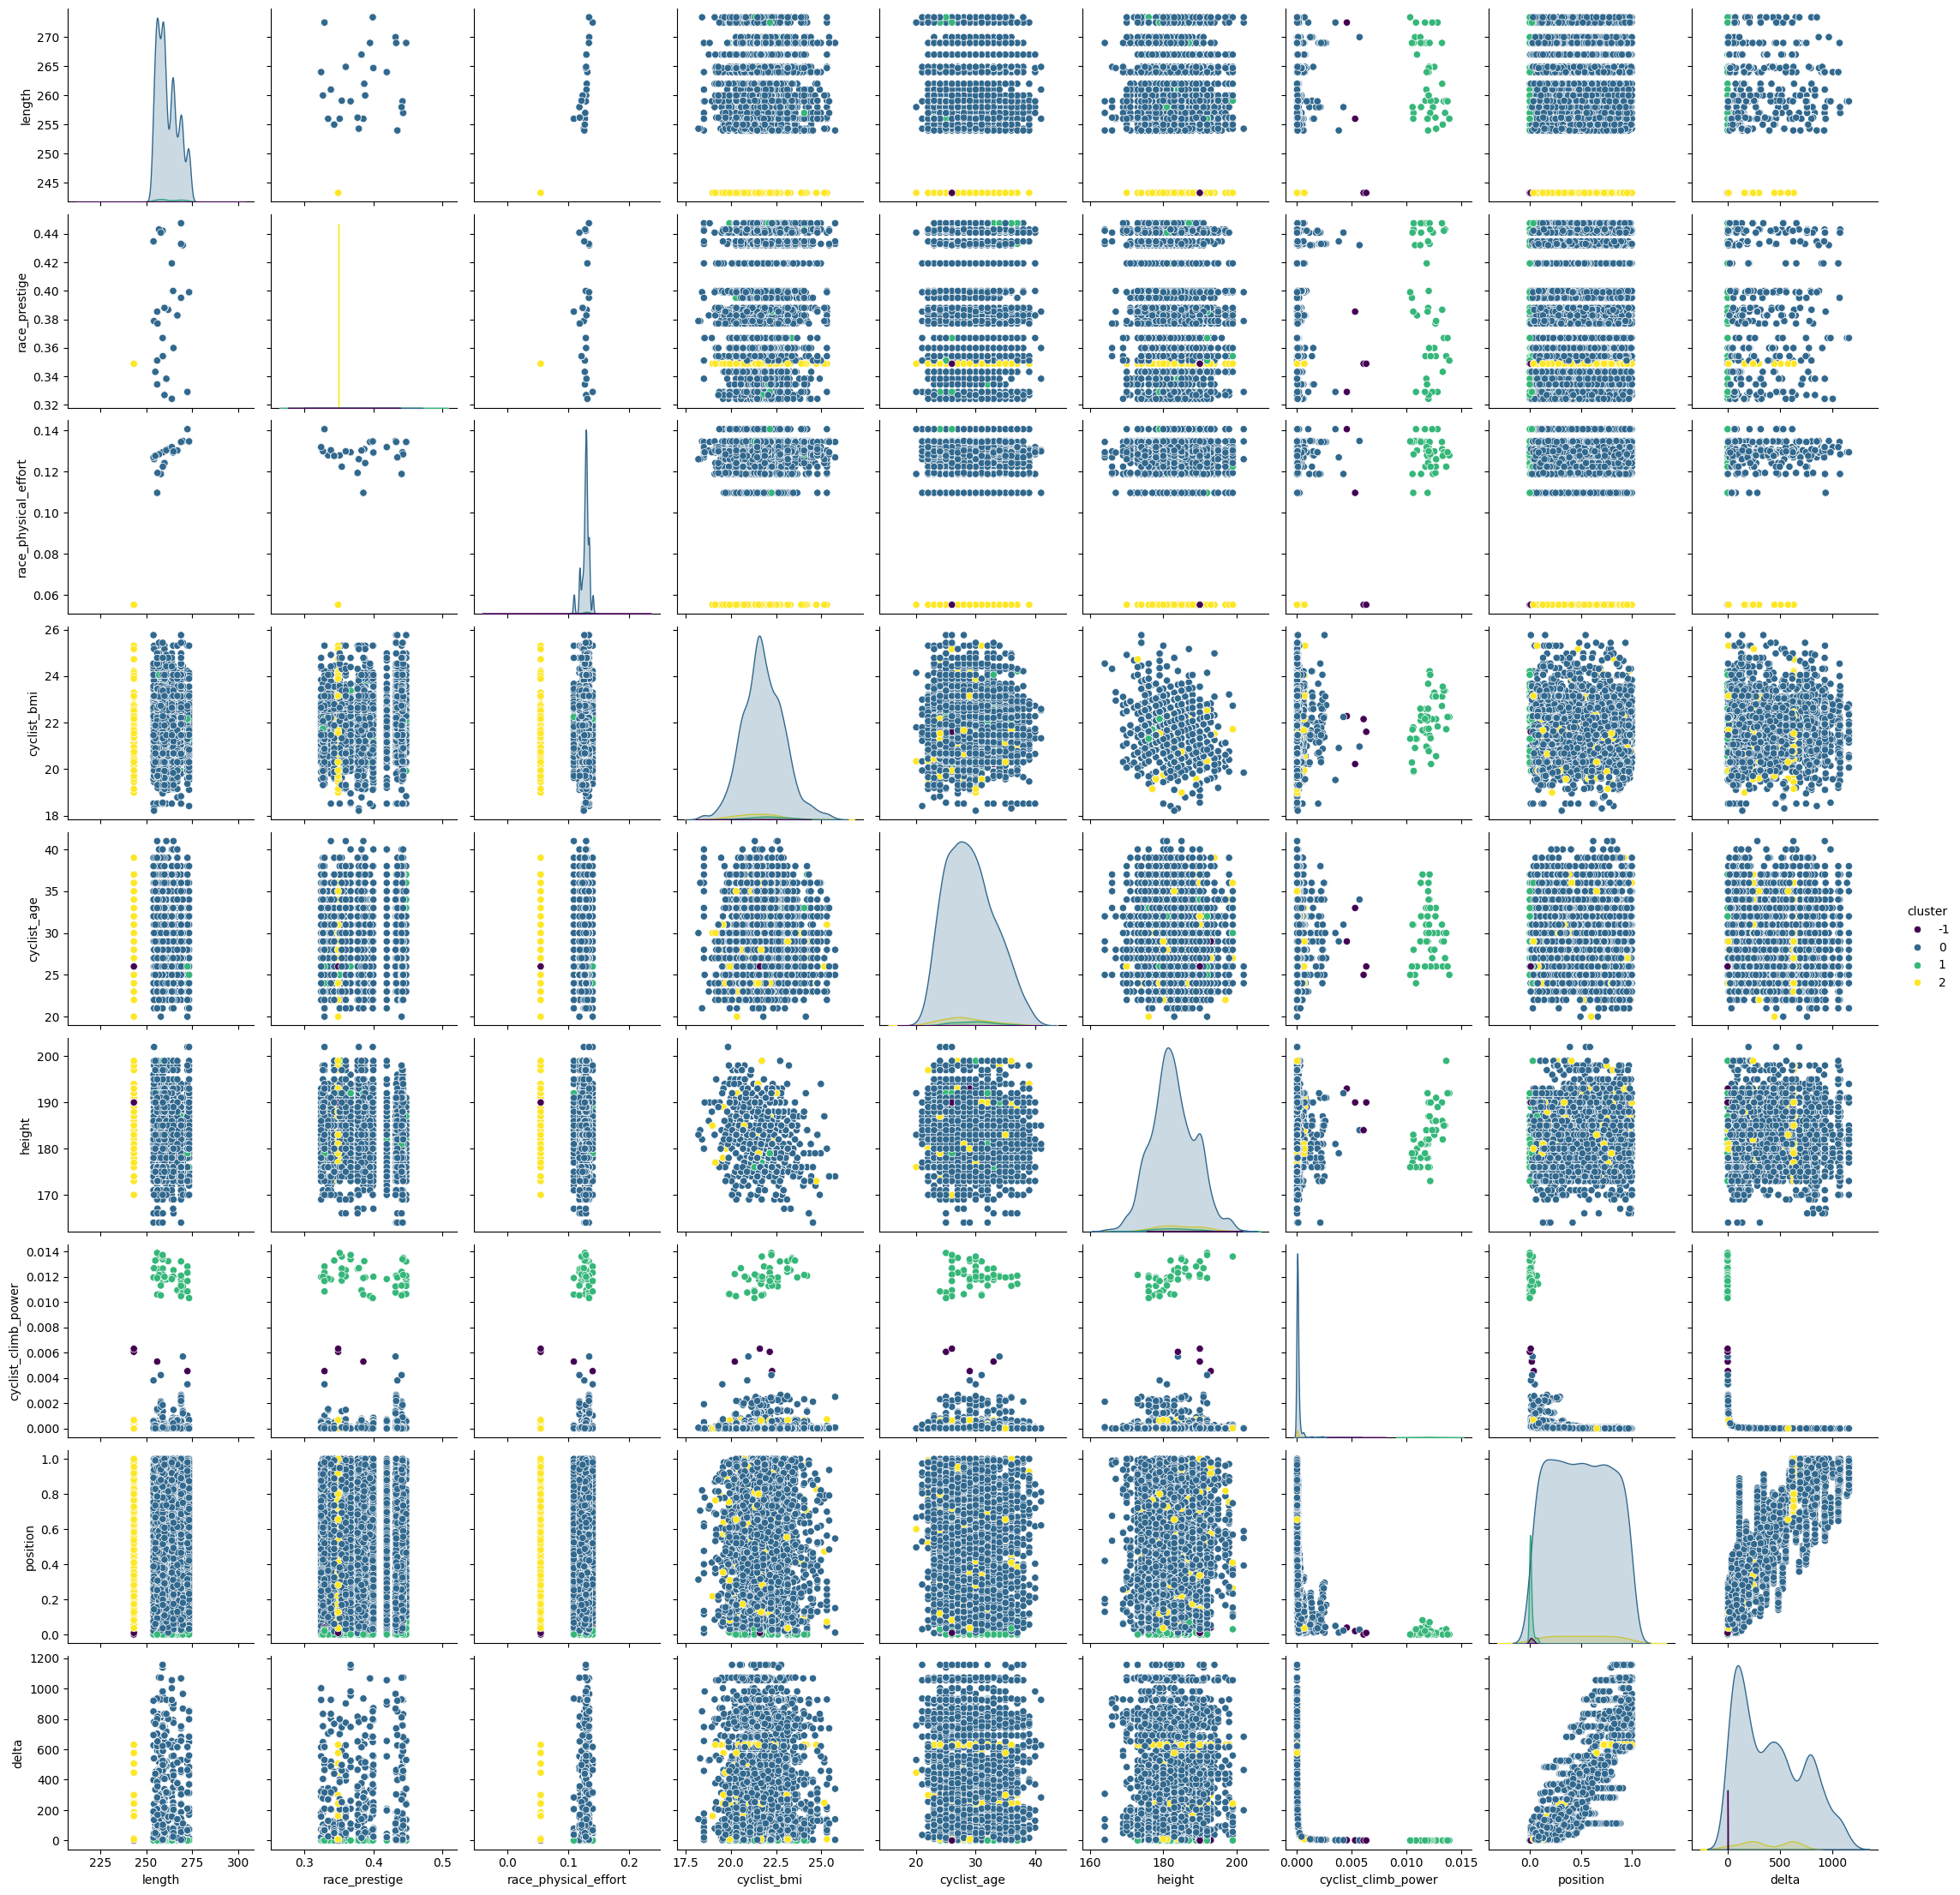

In [24]:
# Pair plot for a subset of columns
data_subset = data_for_clustering[columns_to_use + ['cluster']]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

In [25]:
%matplotlib widget

x = data_for_clustering['position']  # Prima feature
y = data_for_clustering['length']  # Seconda feature
z = data_for_clustering['race_physical_effort']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('position')
ax.set_ylabel('length')
ax.set_zlabel('race_physical_effort')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

RuntimeError: 'widget is not a recognised GUI loop or backend name

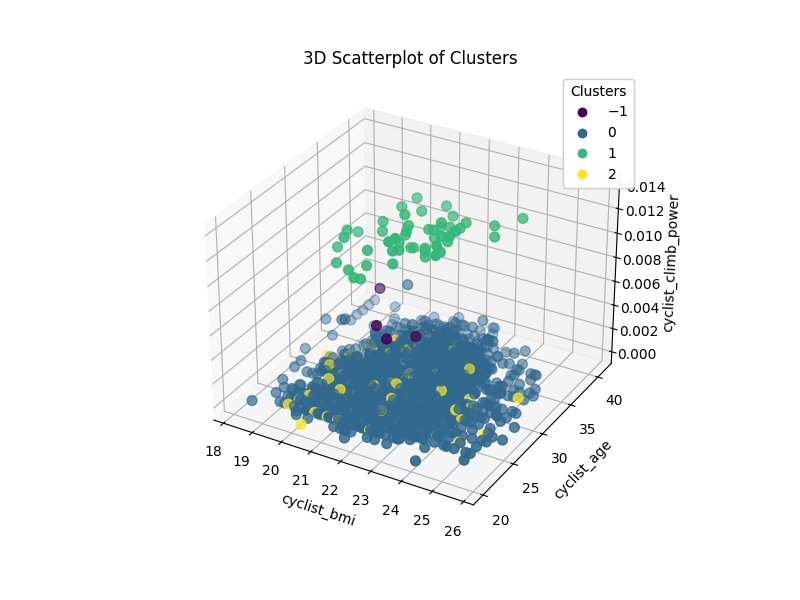

In [ ]:
%matplotlib widget

x = data_for_clustering['cyclist_bmi']  # Prima feature
y = data_for_clustering['cyclist_age']  # Seconda feature
z = data_for_clustering['cyclist_climb_power']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('cyclist_bmi')
ax.set_ylabel('cyclist_age')
ax.set_zlabel('cyclist_climb_power')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

Analysing the plots, we can see that density-based clustering through DBSCAN revealed the presence of three relevant clusters.
In particular, looking at the data with respect to the size of the ‘position’, ‘lenght’, "race_physical_effort" and "cyclist_climb_power" features, we can clearly observe the result of DBSCAN's behaviour, with clusters of varying shapes and densely packed within them.

The clusters can be analysed as follows (colour references and labels in the plots):
- yellow (2) : records associated to cyclists classified in stages of less than average length and low required physical effort 
- green (1): records clearly representative of cyclists-performances demonstrating above-average climb power (clearly visible from the two-dimensional pair-scatter-plots with this attribute in evidence)
- dark blue (-1): outliers
- blue (0): remaining records

In [ ]:
data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.5637477731265932
